Total images: 25000
Sample image files: ['0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg']


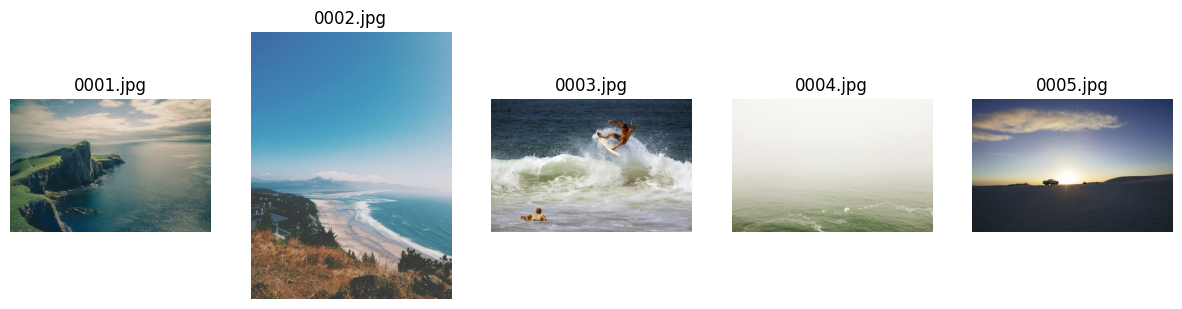

In [1]:
# --- Cell 1: Import Libraries ---
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

# --- Cell 2: Load CSV and Inspect ---
df = pd.read_csv("photos_url.csv")
print(f"Total images: {len(df)}")
df.head()

# --- Cell 3: Check Images Directory ---
image_dir = "images"
sample_files = os.listdir(image_dir)[:5]
print("Sample image files:", sample_files)

# --- Cell 4: Display Sample Images ---
fig, axs = plt.subplots(1, len(sample_files), figsize=(15, 5))
for ax, fname in zip(axs, sample_files):
    img_path = os.path.join(image_dir, fname)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(fname)
    ax.axis('off')
plt.show()

In [2]:
# --- Cell 5: Check for Missing or Corrupt Images ---
missing = []
corrupt = []
for idx, row in df.iterrows():
    img_name = f"{idx+1:04d}.jpg"
    img_path = os.path.join(image_dir, img_name)
    if not os.path.exists(img_path):
        missing.append(img_name)
        continue
    try:
        with Image.open(img_path) as img:
            img.verify()
    except Exception:
        corrupt.append(img_name)

print(f"Missing images: {len(missing)}")
print(f"Corrupt images: {len(corrupt)}")
if missing: print("Missing:", missing[:5])
if corrupt: print("Corrupt:", corrupt[:5])

Missing images: 57
Corrupt images: 0
Missing: ['0771.jpg', '0827.jpg', '0828.jpg', '0829.jpg', '0830.jpg']


In [3]:
# --- Cell 6: Image Size Distribution ---
sizes = []
for fname in sample_files:
    img_path = os.path.join(image_dir, fname)
    with Image.open(img_path) as img:
        sizes.append(img.size)
print("Sample image sizes:", sizes)

Sample image sizes: [(800, 530), (600, 800), (800, 533), (800, 533), (800, 533)]


In [4]:
# --- Cell 7: Generate CLIP Embeddings for Images ---
import torch
import clip
from tqdm import tqdm
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

embeddings = []
valid_indices = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_name = f"{idx+1:04d}.jpg"
    img_path = os.path.join(image_dir, img_name)
    if not os.path.exists(img_path):
        continue
    try:
        image = Image.open(img_path).convert("RGB")
        image_input = preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image_input)
            image_features /= image_features.norm(dim=-1, keepdim=True)
        embeddings.append(image_features.cpu().numpy())
        valid_indices.append(idx)
    except Exception as e:
        print(f"Error processing {img_name}: {e}")

embeddings = np.concatenate(embeddings, axis=0)
np.save("clip_image_embeddings.npy", embeddings)
np.save("clip_valid_indices.npy", np.array(valid_indices))
print(f"Saved embeddings for {len(embeddings)} images.")

100%|███████████████████████████████████████| 338M/338M [00:28<00:00, 12.4MiB/s]
100%|██████████| 25000/25000 [1:06:15<00:00,  6.29it/s]


Saved embeddings for 24943 images.


In [10]:
import torch, clip, faiss, json, numpy as np, os

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load FAISS index and metadata
index_path = r"C:\Users\vaibhava\usecasedev\image_search_case_study\data\faiss.index"
metadata_path = r"C:\Users\vaibhava\usecasedev\image_search_case_study\data\metadata.json"

index = faiss.read_index(index_path)

with open(metadata_path, "r") as f:
    metadata = json.load(f)

def search_text(query, top_k=5):
    with torch.no_grad():
        tokens = clip.tokenize([query]).to(device)
        text_features = model.encode_text(tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        q = text_features.cpu().numpy().astype("float32")

    scores, ids = index.search(q, top_k)
    results = []
    for score, idx in zip(scores[0], ids[0]):
        results.append({
            "filename": metadata[idx]["filename"],
            "path": metadata[idx]["path"],
            "score": float(score)
        })
    return results


In [11]:
# 🧠 Test search
query = "horse"
results = search_text(query)
for r in results:
    print(r)

{'filename': '1030.jpg', 'path': 'data/images\\1030.jpg', 'score': 0.2987020015716553}
{'filename': '23597.jpg', 'path': 'data/images\\23597.jpg', 'score': 0.29852038621902466}
{'filename': '16991.jpg', 'path': 'data/images\\16991.jpg', 'score': 0.2983986735343933}
{'filename': '1358.jpg', 'path': 'data/images\\1358.jpg', 'score': 0.29662662744522095}
{'filename': '9091.jpg', 'path': 'data/images\\9091.jpg', 'score': 0.29468396306037903}


In [12]:
import sys
print(sys.executable)
import torch
print(torch.__version__)


c:\Users\vaibhava\usecasedev\.python\Scripts\python.exe
2.9.0+cpu
